In [2]:
import os
import matplotlib
from Model.model import log

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()
os.chdir(ROOT_DIR)

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to COCO trained weights
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

MODEL_PATH = os.path.join(ROOT_DIR, "Weights\mask_rcnn_irises_Ubiris.h5" )

d:\itb\sem8\TA2\multipurpose-iris-recognition\core\modules\IrisSeg\Model\model.py:2316: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if os.name is 'nt':


In [3]:
import Model.model as modellib

from Model.config import Config

class irisConfig(Config):
    # Give the configuration a recognizable name
    NAME = "irises"

    GPU_COUNT = 1
    IMAGES_PER_GPU = 2

    NUM_CLASSES = 1 + 1  # background + 3 shapes

    IMAGE_MIN_DIM = 640
    IMAGE_MAX_DIM = 640

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 1000

    VALIDATION_STEPS = 50
    
class InferenceConfig(irisConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()
inference_config.display()
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

#Loads weights from a static model file
model.load_weights(MODEL_PATH, by_name=True)


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  640
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  640
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [640 640   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           irises
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS

In [4]:
import numpy as np
import Model.utils as utils
from skimage import color

def resize(image):
    im, window, scale, padding, crop = utils.resize_image(
        image,
        min_dim=inference_config.IMAGE_MIN_DIM,
        min_scale=inference_config.IMAGE_MIN_SCALE,
        max_dim=inference_config.IMAGE_MAX_DIM,
        mode="pad64"
    )

    return im

def infer(image):
    r = model.detect([image], verbose=0)
    return r[0]

def segment(image, bbox, mask):
    PADDING = 20

    cx = ((bbox[0]+bbox[2])//2)
    cy = ((bbox[1]+bbox[3])//2)

    croppedMask = mask[bbox[0]-PADDING:bbox[2]+PADDING, bbox[1]-PADDING:bbox[3]+PADDING]
    croppedIm = image[bbox[0]-PADDING:bbox[2]+PADDING, bbox[1]-PADDING:bbox[3]+PADDING]

    tIm = croppedIm
    croppedMask = croppedMask*255
    croppedMask = color.gray2rgb(croppedMask)
    
    anded = np.bitwise_and(tIm, croppedMask)

    return anded, croppedMask

def run(image):
    img = resize(image)
    r = infer(img)
    bbox = r['rois'][0]
    mask = r['masks'][:, :, 0]
    anded, _ = segment(img, bbox, mask)

    return img, bbox, anded, r

In [5]:
import matplotlib.pyplot as plt
import os
import glob
import re

from skimage import img_as_uint
from skimage.io import imread, imshow, imsave
import time

from Model import visualize

# Load images from folder
def numericalSort(value):
    numbers = re.compile(r'(\d+)')
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax        

#Inference one at a time, change to batch (Memory per image calculate)
def runOnFolder(inputFolder,saveFolder,maskFolder):
    os.chdir(folderPath)
    imList = sorted(glob.glob("*"),key=numericalSort)
    print (len(imList))
    
    irisFolder = saveFolder
    if not os.path.exists(irisFolder):
        os.makedirs(irisFolder)
        
    maskFolder = maskFolder
    if not os.path.exists(maskFolder):
        os.makedirs(maskFolder)
    os.chdir(irisFolder)
    
    newpath = saveFolder
    if not os.path.exists(newpath):
        os.makedirs(newpath)

    print ("Saving in " + os.getcwd())

    for i in range(len(imList)):
        im = imread(folderPath + "/" + imList[i])

        start = time.time()
        img, bbox, anded, r = run(im)
        end = time.time()

        print(end-start)

        visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], ['BG', 'Iris'], show_bbox = True, ax=get_ax())

2
Saving in d:\itb\sem8\TA2\multipurpose-iris-recognition\core\modules\IrisSeg\segmented
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
9.494483709335327
0.6281101703643799


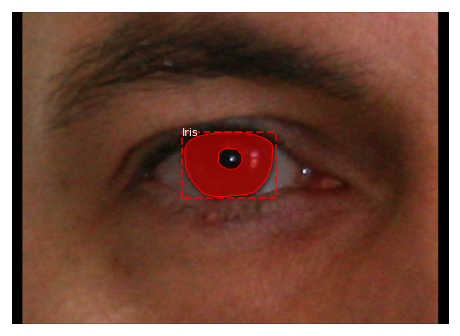

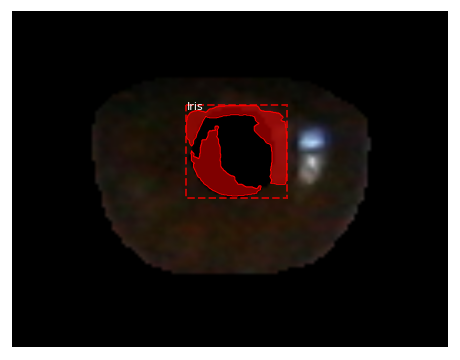

In [6]:
folderPath = os.path.join(ROOT_DIR, '..', '..', '..', "datasets")
runOnFolder(folderPath, ROOT_DIR+"/segmented", ROOT_DIR+"/masks")